In [38]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm

from src import ROOT_DIR
from src.datasets import MixedDataset, BildacherBackgroundDataset, OUT_IMAGE_RES
from src.utils import (
    is_bbox_outside_crop,
    get_patch_label,
    plot_tensor,
    unpack_yolo_label,
    yolo_bbox_relative_to_absolute_coords,
    )

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mixed dataset

In [3]:
dataset = MixedDataset(center_crop=False)

In [4]:
dataset.transforms.transforms

[ToTensor()]

In [5]:
image, label, patch = dataset[1]
image.shape, label, patch

(torch.Size([3, 1408, 2048]),
 array([[0.       , 0.603601 , 0.0288241, 0.0702783, 0.0576483],
        [0.       , 0.4438354, 0.569934 , 0.085708 , 0.1343443],
        [0.       , 0.8816699, 0.0546849, 0.1143945, 0.1093699]]),
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=176x189>)

### Check patches

In [6]:
label, label.shape 

(array([[0.       , 0.603601 , 0.0288241, 0.0702783, 0.0576483],
        [0.       , 0.4438354, 0.569934 , 0.085708 , 0.1343443],
        [0.       , 0.8816699, 0.0546849, 0.1143945, 0.1093699]]),
 (3, 5))

In [28]:
x, y, w, h = unpack_yolo_label(label[1])
x, y, w, h

(0.4438354, 0.569934, 0.085708, 0.1343443)

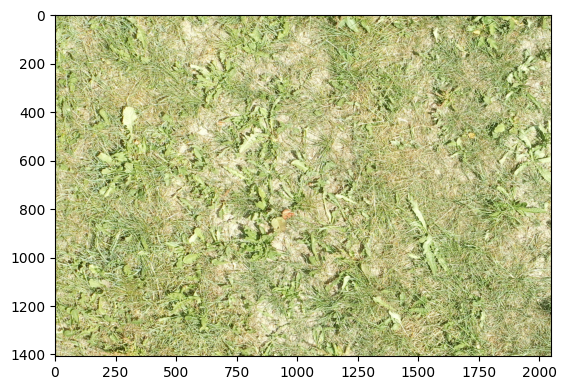

In [29]:
plot_tensor(image)
H = image.shape[1]
W = image.shape[2]

In [30]:
patch_height = round(h * H)
patch_width = round(w * W)
patch_height, patch_width

(189, 176)

In [31]:
x_center = round(x * W)
y_center = round(y * H)
_patch = image[:, y_center - patch_height//2 : y_center + patch_height//2, x_center - patch_width//2 : x_center + patch_width//2]

torch.Size([3, 188, 176])


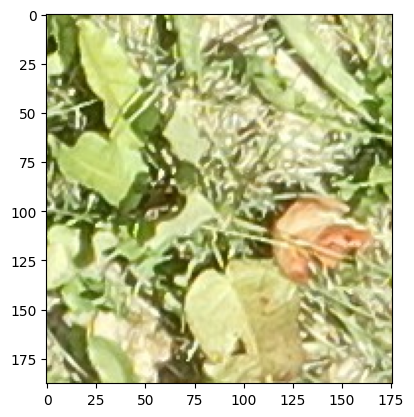

In [32]:
print(_patch.shape)
plot_tensor(_patch)

torch.Size([3, 189, 176])


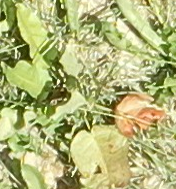

In [33]:
print(pil_to_tensor(patch).shape)
patch

**Patch extracted from labels match! (before doing CenterCrop)**

### Discard labels, patches and images when any part of the BBox is outside CenterCrop

In [34]:
dataset = MixedDataset(center_crop=True)

In [35]:
image, label, patch = dataset[1]
label

array([[0.       , 0.603601 , 0.0288241, 0.0702783, 0.0576483],
       [0.       , 0.4438354, 0.569934 , 0.085708 , 0.1343443],
       [0.       , 0.8816699, 0.0546849, 0.1143945, 0.1093699]])

In [36]:
# ## Test -> seems to work
# for i in range(len(dataset)):
#     image, label, patch = dataset[i]
#     patch_height, patch_width = pil_to_tensor(patch).shape[1:]
#     H, W = image.shape[1], image.shape[2]
#     label_match = get_patch_label(image, label, patch)
#     x, y, w, h = unpack_yolo_label(label_match)
#     x, y, w, h = yolo_bbox_relative_to_absolute_coords(x, y, w, h, W, H)
#     print(h, w)
#     print(patch_height, patch_width)    

In [41]:
patches_to_discard = []
labels = []
for i in tqdm(range(len(dataset))):
    image, label, patch = dataset[i]
    
    # There are more than one bbox per image, we need to find which one is the one that we see in the patch
    # Finding closest match by patch size:  
    patch_height, patch_width = pil_to_tensor(patch).shape[1:]
    H, W = image.shape[1], image.shape[2]
    label_match = get_patch_label(image, label, patch)
    labels.append(label_match)
    
    ## BBox coordinates
    x, y, w, h = unpack_yolo_label(label_match)
    x, y, w, h = yolo_bbox_relative_to_absolute_coords(x, y, w, h, W, H)
    if is_bbox_outside_crop(x, y, w, h, W, H, OUT_IMAGE_RES):
        patches_to_discard.append(i)
        
patches_to_discard

100%|██████████| 584/584 [01:01<00:00,  9.44it/s]


[2, 184, 225, 270, 347, 362, 371, 373, 494]

In [39]:
len(patches_to_discard)

9

In [43]:
l1 = [1, 2, 3, 4, 5]
l2 = [2, 3]
filtered_list = [element for index, element in enumerate(l1) if index not in l2]

print(filtered_list)  # Output: [1, 3, 5]

[1, 2, 5]


## Bildacher backgrounds dataset

In [ ]:
bildacher = BildacherBackgroundDataset()
image = bildacher[0]
print(image.shape)
plot_tensor(image)